# Code from here https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet

# another simple example https://www.kaggle.com/toregil/a-lung-u-net-in-keras/code

In [1]:
import numpy as np
import os
import smtplib
from keras.applications.resnet50 import ResNet50
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, Conv3DTranspose, Concatenate
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Conv2DTranspose, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Input, BatchNormalization, Lambda, UpSampling3D
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os

os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

def notify_me(msg):
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    with open('/home/tkyono/.emailsettings') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    server.login(content[0], content[1])
    server.sendmail('DeepLearningBox', '8084460540@vtext.com', msg)

Using TensorFlow backend.


In [2]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)




In [3]:
def read_hdf5(path, num_images):
    import h5py
    import pylab
    print(path)
    fh = h5py.File(path, 'r')

def show_img(img):
    pylab.imshow(img)
    pylab.colorbar()
    pylab.show()
    
def show_img_zoom(img):
    pylab.imshow(img)
    pylab.axis([1000,2000,1500,2500])
    pylab.colorbar()
    pylab.show()
    
    
import h5py
import pylab  



# Do Phase

In [4]:

from PIL import Image
from keras.preprocessing import image

def get_generator(train_folder, train_mask_folder, valid_folder, valid_mask_folder,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    rotation_range=10,
                    zoom_range=0.2,
                    samplewise_center = False,
                    samplewise_std_normalization = False,
                    #rescale = 1/65535.0,
                  #rescale = 1,  
                  classes=['keras'],
                    fill_mode="constant"):

    #batch_size = 12
    seed = 42
    image_datagen = ImageDataGenerator(width_shift_range=width_shift_range,
                        height_shift_range=height_shift_range,
                        horizontal_flip=horizontal_flip,
                        rotation_range=rotation_range,
                        zoom_range=zoom_range,
                        samplewise_center = samplewise_center,
                        samplewise_std_normalization = samplewise_std_normalization,
                        fill_mode=fill_mode, 
                        cval=0       )
    mask_datagen = ImageDataGenerator(width_shift_range=width_shift_range,
                        height_shift_range=height_shift_range,
                        horizontal_flip=horizontal_flip,
                        rotation_range=rotation_range,
                        zoom_range=zoom_range,
                        fill_mode=fill_mode,
                        cval=0    )

    
    image_generator = image_datagen.flow_from_directory(train_folder,
        batch_size = batch_size,target_size = (64,64),
        class_mode=None,
        color_mode='grayscale',
        #classes=classes,
        seed=seed
    )
    mask_generator = mask_datagen.flow_from_directory(train_mask_folder,
        batch_size = batch_size, target_size = (64,64),    
        class_mode=None,
        color_mode='grayscale',
        #classes=classes,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [12]:



#tanh was pretty close....
def get_unet():

    inputs = Input((25, 64, 64, 1))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (1, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(1024, (1, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(512, (1, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(256, (1, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(128, (1, 3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(64, (1, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


def get_unet():
    inputs = Input((64, 64, 1))
    bn = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bn)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, (1, 1), activation='tanh')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    #model.compile(optimizer=optimizers.Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = get_unet()
plot_model(model, to_file='unet1.png', show_shapes=True)

def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def normalize2(A):
    #return A
    return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))


train_dir = '/home/tkyono/Desktop/bispectrum_training/*.h5'
val_dir = '/home/tkyono/Desktop/bispectrum_training/validate/*.h5'
batch_size = 1
num_files = 0
for i in glob.glob(train_dir):
    num_files += 1
    
    
    
image_datagen = ImageDataGenerator(width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        vertical_flip =True,
                        rotation_range=0.1,
                        zoom_range=0.2,
                        samplewise_center = False,
                        samplewise_std_normalization = False,
                        fill_mode='nearest', 
                        cval=0       )
#print("Found ", num_files, "files")
import random
def generate(d): #changed all REAL to PHASE and all IMAGINARY to MAG
    while True:
        #print("Recycling through files")
        for i in glob.glob(d):
            #print("Opening new file", i)
            hdf5 = h5py.File(i, 'r')
            num_images = len(hdf5['Degraded_imaginary']) // batch_size
            for j in range(num_images):
                Xr = []
                Yr = []
                j = batch_size * j
                F1Xr = hdf5['Degraded_imaginary'][j:j + batch_size]
                F1Xr = np.reshape(F1Xr,(25, 64,64))
                F1Yr = hdf5['Pristine_imaginary'][j:j + batch_size]
                F1Yr = np.reshape(F1Yr, (25, 64,64))
                #F1Xr = np.moveaxis(F1Xr, 1, 4)
                for i in range(len(F1Xr)):
                    seed = random.randint(0,10000)
                    Xr.append(normalize(image_datagen.random_transform(np.reshape(F1Xr[i], (64,64,1)), seed))) 
                    Yr.append(normalize(image_datagen.random_transform(np.reshape(F1Yr[i], (64,64,1)), seed))) 
                    
                #F1Yr = np.moveaxis(F1Yr, 1, 4)
                Xr = np.array(Xr)    
                Yr = np.array(Yr)    

                yield np.reshape(Xr, (25, 64, 64, 1)) , np.reshape(Yr, (25,  64, 64, 1))
            hdf5.close()
            
callbacks = [ModelCheckpoint('best_im', verbose=1, monitor='val_mean_squared_error',save_best_only=True),
            EarlyStopping(monitor='val_mean_squared_error', min_delta=0.00001, patience=2, verbose=1, mode='auto')
           ]

model.compile(optimizer=optimizers.Adam(lr = 1e-3),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
            

model = load_model('best_im')
model.compile(optimizer=optimizers.Adam(lr = 1e-4),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)


model = load_model('best_im')
model.compile(optimizer=optimizers.Adam(lr = 1e-5),metrics = [ 'mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
  



Epoch 1/100
10000/10000 [==============================] - 444s 44ms/step - loss: 1.5601e-04 - mean_squared_error: 1.5601e-04 - val_loss: 1.6154e-04 - val_mean_squared_error: 1.6154e-04

Epoch 00001: val_mean_squared_error improved from inf to 0.00016, saving model to best_im
Epoch 2/100
10000/10000 [==============================] - 435s 44ms/step - loss: 1.7060e-05 - mean_squared_error: 1.7060e-05 - val_loss: 8.1951e-05 - val_mean_squared_error: 8.1951e-05

Epoch 00002: val_mean_squared_error improved from 0.00016 to 0.00008, saving model to best_im
Epoch 3/100
10000/10000 [==============================] - 437s 44ms/step - loss: 1.7075e-05 - mean_squared_error: 1.7075e-05 - val_loss: 7.7982e-05 - val_mean_squared_error: 7.7982e-05

Epoch 00003: val_mean_squared_error improved from 0.00008 to 0.00008, saving model to best_im
Epoch 4/100
10000/10000 [==============================] - 438s 44ms/step - loss: 1.3259e-05 - mean_squared_error: 1.3259e-05 - val_loss: 8.4170e-05 - val_mean_s

(25, 64, 64, 1)
0.4948036
************** i =  0
Predicted


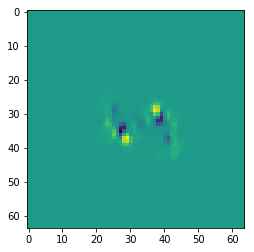

-0.0748818 0.062952824
Noisy


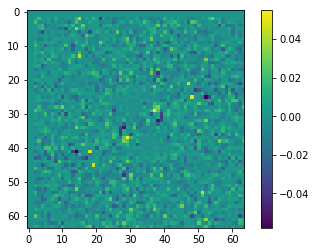

-0.057807092118446916 0.054865996190709865
Pristine


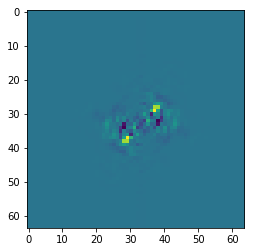

0.0 1.0
************** i =  1
Predicted


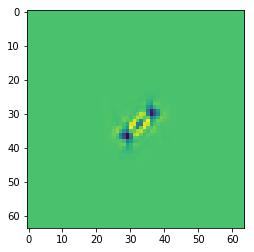

-0.096618 0.039309986
Noisy


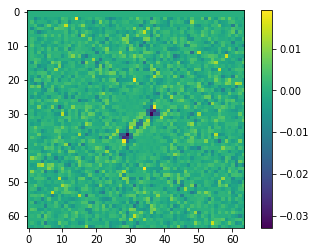

-0.03293141813439411 0.019177057882334373
Pristine


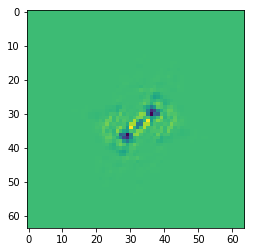

0.0 1.0
************** i =  2
Predicted


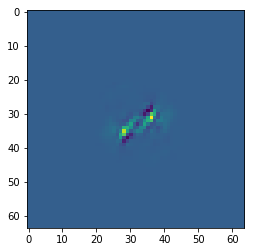

-0.09286587 0.21497098
Noisy


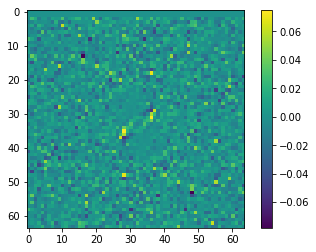

-0.07807908747494871 0.07485688411426598
Pristine


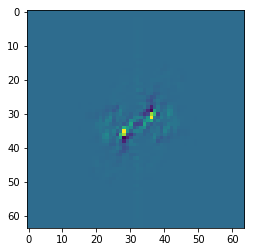

0.0 1.0
************** i =  3
Predicted


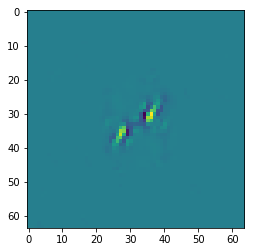

-0.3754908 0.4948036
Noisy


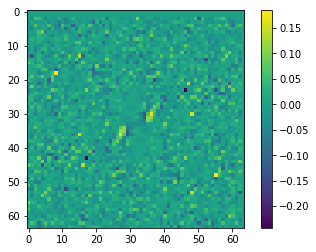

-0.24248641968888263 0.18430823717843742
Pristine


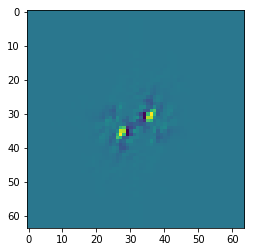

0.0 1.0
************** i =  4
Predicted


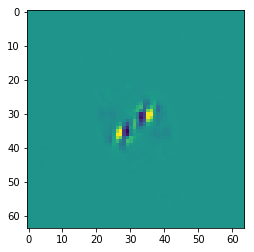

-0.32859945 0.30618593
Noisy


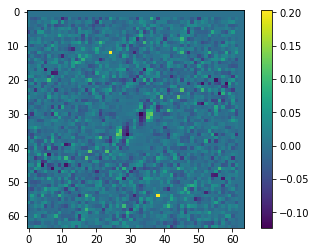

-0.12330459849209338 0.20282500679891535
Pristine


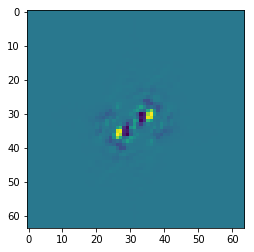

0.0 1.0
************** i =  5
Predicted


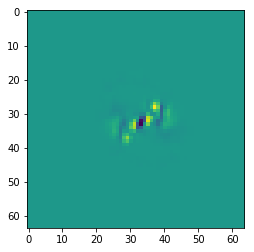

-0.09930497 0.087581396
Noisy


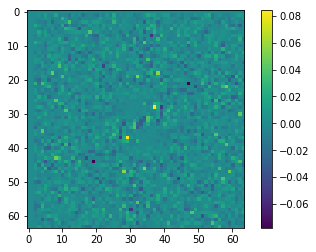

-0.07766784088405282 0.08396891907181295
Pristine


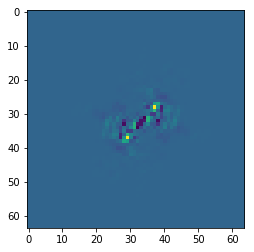

0.0 1.0
************** i =  6
Predicted


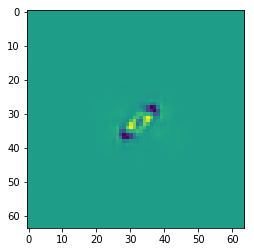

-0.23091342 0.18285307
Noisy


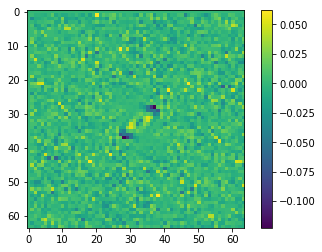

-0.12264357390952586 0.061901750856995286
Pristine


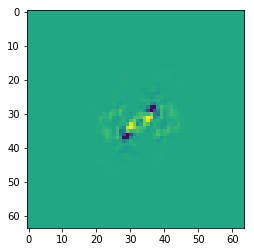

0.0 1.0
************** i =  7
Predicted


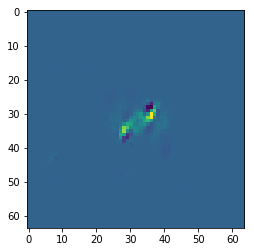

-0.082179315 0.17725687
Noisy


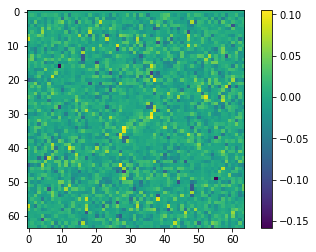

-0.15831609858488105 0.10471542087398181
Pristine


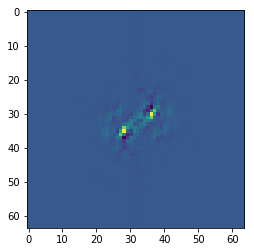

0.0 1.0
************** i =  8
Predicted


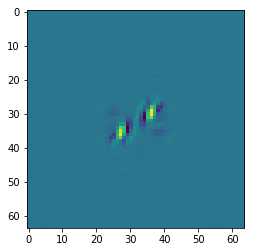

-0.2597952 0.40232322
Noisy


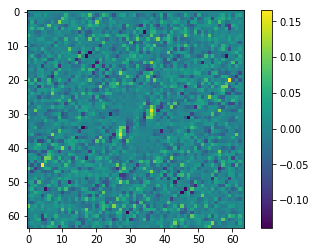

-0.13903310557658174 0.1654810936648362
Pristine


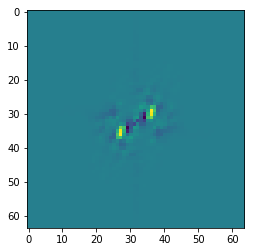

0.0 1.0
************** i =  9
Predicted


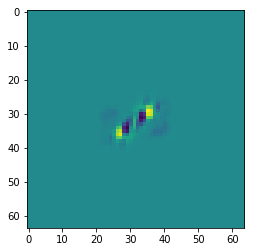

-0.35857537 0.39142764
Noisy


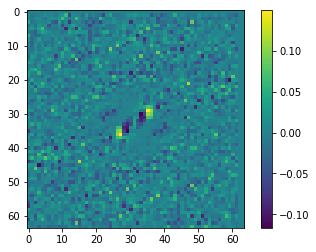

-0.11664872483852146 0.14982984385382714
Pristine


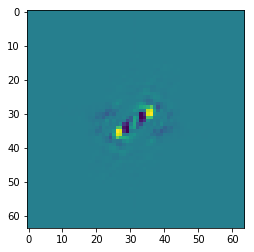

0.0 1.0
************** i =  10
Predicted


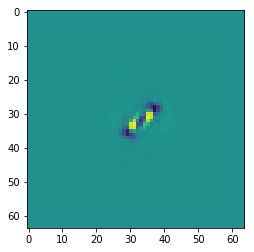

-0.19399968 0.19014697
Noisy


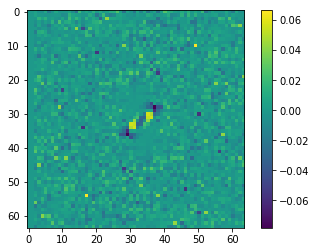

-0.07837918924215809 0.0665218864136928
Pristine


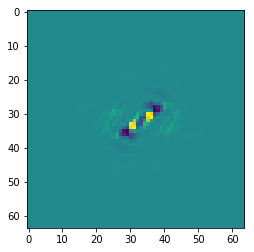

0.0 1.0
************** i =  11
Predicted


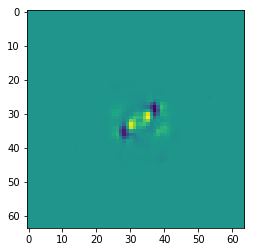

-0.2945001 0.27116072
Noisy


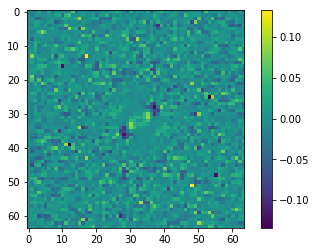

-0.13398620157563249 0.13285223028155743
Pristine


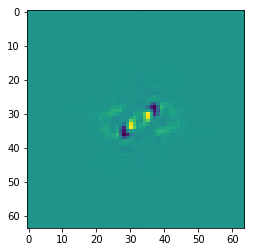

0.0 1.0
************** i =  12
Predicted


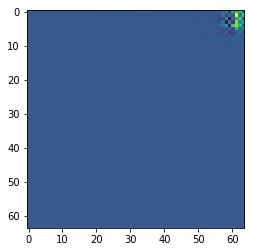

-0.059511963 0.15617757
Noisy


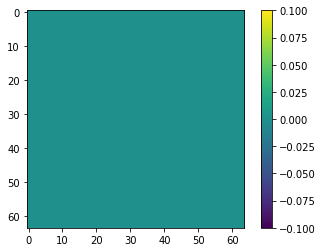

0.0 0.0
Pristine


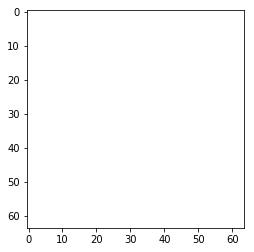

nan nan
************** i =  13
Predicted


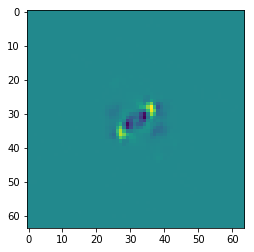

-0.26973367 0.300631
Noisy


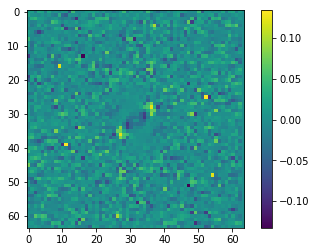

-0.13285223028155743 0.13398620157563249
Pristine


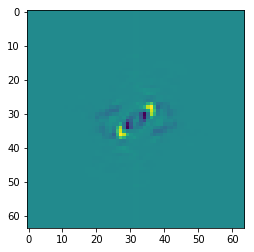

0.0 1.0
************** i =  14
Predicted


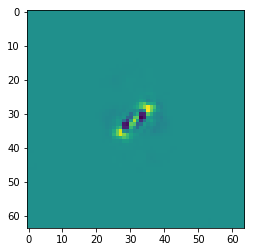

-0.19469891 0.19476417
Noisy


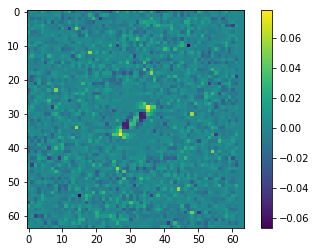

-0.0665218864136928 0.07837918924215809
Pristine


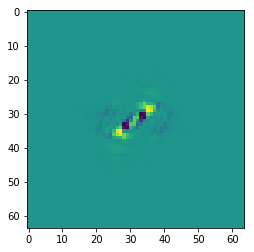

0.0 1.0
************** i =  15
Predicted


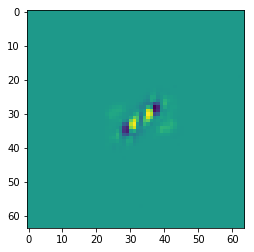

-0.4160314 0.35879144
Noisy


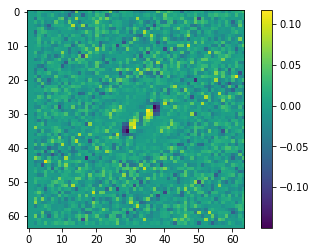

-0.14982984385382714 0.11664872483852146
Pristine


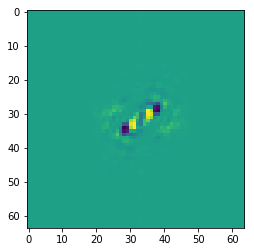

0.0 1.0
************** i =  16
Predicted


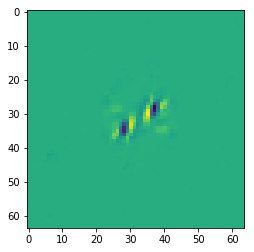

-0.45929465 0.27815935
Noisy


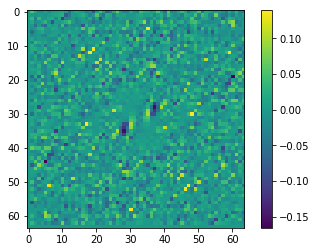

-0.1654810936648362 0.13903310557658174
Pristine


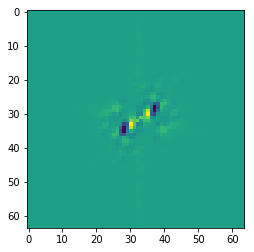

0.0 1.0
************** i =  17
Predicted


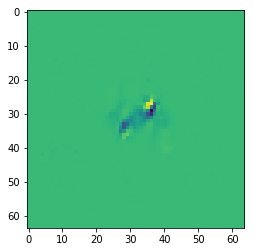

-0.19630037 0.09608169
Noisy


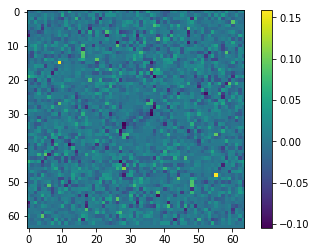

-0.10471542087398181 0.15831609858488105
Pristine


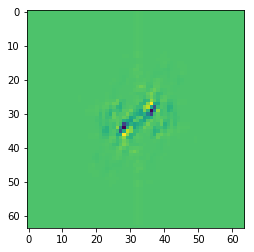

0.0 1.0
************** i =  18
Predicted


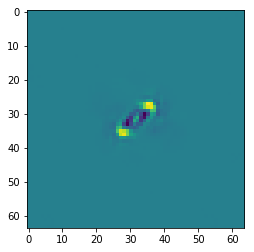

-0.17690137 0.23156337
Noisy


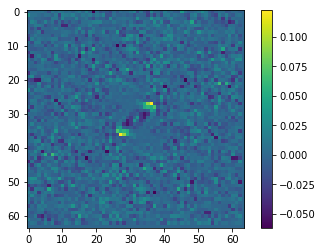

-0.061901750856995286 0.12264357390952586
Pristine


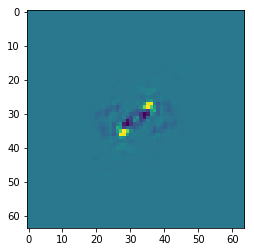

0.0 1.0
************** i =  19
Predicted


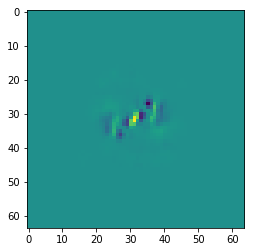

-0.09109312 0.09069297
Noisy


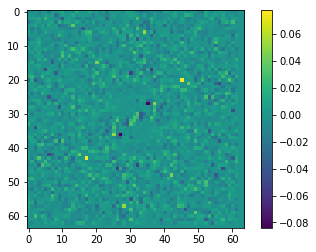

-0.08396891907181295 0.07766784088405282
Pristine


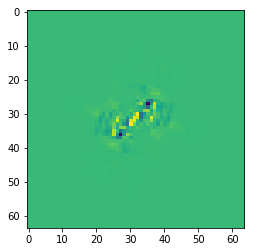

0.0 1.0
************** i =  20
Predicted


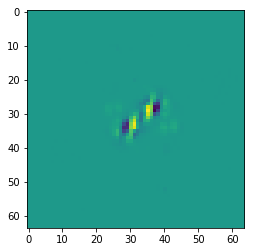

-0.36575654 0.31609404
Noisy


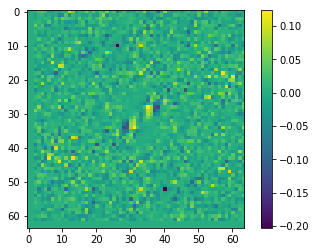

-0.20282500679891535 0.12330459849209338
Pristine


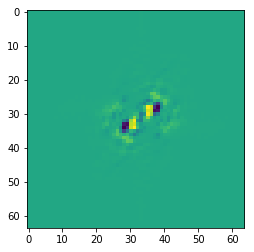

0.0 1.0
************** i =  21
Predicted


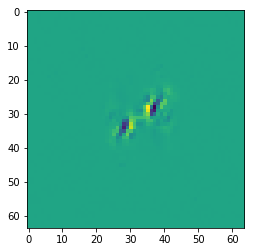

-0.5308126 0.3752622
Noisy


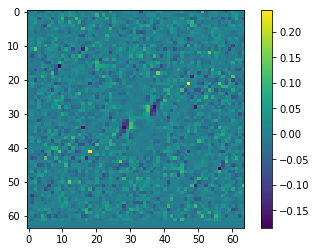

-0.18430823717843742 0.24248641968888263
Pristine


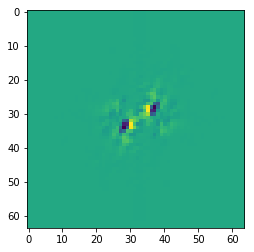

0.0 1.0
************** i =  22
Predicted


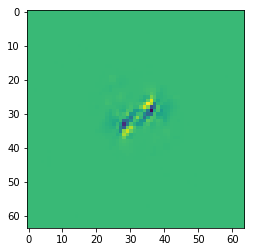

-0.21461812 0.10325327
Noisy


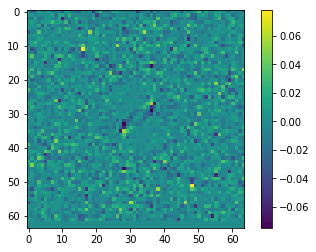

-0.07485688411426598 0.07807908747494871
Pristine


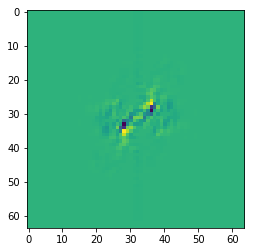

0.0 1.0
************** i =  23
Predicted


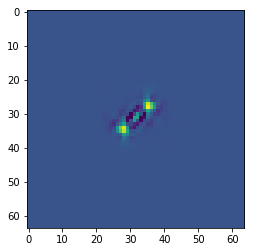

-0.035161354 0.10240559
Noisy


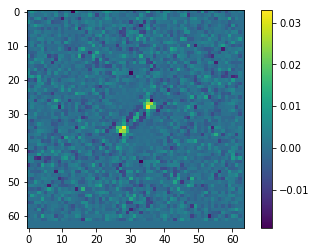

-0.019177057882334373 0.03293141813439411
Pristine


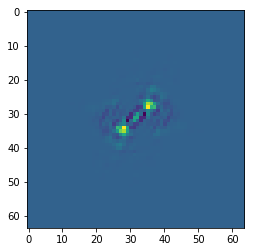

0.0 1.0
************** i =  24
Predicted


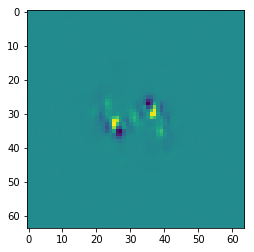

-0.07088554 0.07727049
Noisy


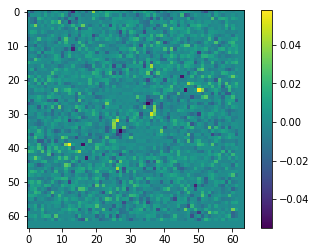

-0.054865996190709865 0.057807092118446916
Pristine


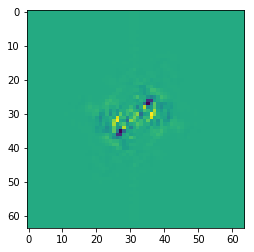

0.0 1.0


In [13]:
def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))

model = load_model('best_im')
test_dir = '/home/tkyono/Desktop/bispectrum_training/test/bispec_training_validation_20180806.mat_ensemble_1_of_1_scaled_stdev.mat.h5'
Xr = []
Xi = []
Yr = []
Yi = []
hdf5 = h5py.File(test_dir, 'r')
batch_size = 1
j = 0

F1Xr = hdf5['Degraded_imaginary'][j:j + batch_size]
F1Xr = np.reshape(F1Xr,(25, 64,64, 1))

F1Yr = hdf5['Pristine_imaginary'][j:j + batch_size]
F1Yr = np.reshape(F1Yr, (25, 64,64, 1))
#F1Xr = np.moveaxis(F1Xr, 1, 4)


for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i]))

for i in range(len(F1Yr)):
    Yr.append(normalize2(F1Yr[i]))

Xr = np.array(Xr)    
Yr = np.array(Yr)    
        
F1Xr = []
F1Yr = []
Xr = np.array(Xr)    
Yr = np.array(Yr)    


import matplotlib.pyplot as plt


Ypred = model.predict(Xr)
print(Ypred.shape)
print(np.max(Ypred))
for i in range(25):
    print("************** i = ", i)
    print("Predicted")
    plt.imshow(np.squeeze(Ypred[i,:,:]))
    plt.show()
    print(np.min(Ypred[i,:,:]),np.max(Ypred[i,:,:]))
    
    #print("Predicted - Noisy")
    #plt.imshow(Ypred[i,3,:,:,1] - Xr[i,3,:,:,1])
    #plt.show()

    #print("Predicted - Pristine")
    #plt.imshow(Ypred[i,3,:,:,1] - Yr[i,3,:,:,1])
    #plt.show()


    print("Noisy")
    plt.imshow(np.squeeze(Xr[i,:,:]))
    plt.colorbar()
    plt.show()
    print(np.min(Xr[i,:,:]),np.max(Xr[i,:,:]))
    print("Pristine")
    plt.imshow(np.squeeze(Yr[i,:,:]))
    plt.show()
    print(np.min(Yr[i,:,:]),np.max(Yr[i,:,:]))

In [17]:
Xr = []
F1Xr = hdf5['Degraded_imaginary']
F1Xr = np.reshape(F1Xr,(len(F1Xr) * 25, 64,64, 1))

for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i]))


Xr = np.array(Xr)    
F1Xr = []

import matplotlib.pyplot as plt

Ypred = model.predict(Xr)
hf = h5py.File('predicted_imaginary_new.h5', 'w')
hf.create_dataset('imaginary', data = Ypred)
hf.close()

In [18]:
Ypred.shape

Yreshaped = np.reshape(Ypred, (1000, 25, 64,64, 1))

In [19]:
hf = h5py.File('predicted_imaginary_shaped_new.h5', 'w')
hf.create_dataset('imaginary', data = Yreshaped)
hf.close()